In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import json
from dataclasses import dataclass, field
from typing import Dict, List, Optional
import os

from coffea.util import load

In [2]:
cms_color = {
    "blue": "#3f90da",
    "orange": "#ffa90e",
    "red": "#bd1f01",
    "gray": "#94a4a2",
    "purple": "#832db6",
    "brown": "#a96b59",
    "dark_orange": "#e76300",
    "beige": "#b9ac70",
    "dark_gray": "#717581",
    "light_blue": "#92dadd"
}

In [3]:
class Plotter:
    def __init__(self, hist_info):
        self.hist_info = hist_info
        self.colors = [cms_color["orange"], cms_color["purple"], cms_color["red"],
                       cms_color["beige"], cms_color["blue"], cms_color["dark_gray"],
                       cms_color["light_blue"], cms_color["brown"], cms_color["dark_orange"], cms_color["gray"]]

    def define_figure(self):
        self.fig, (self.ax, self.rax) = plt.subplots(
            2, 1, figsize=(10, 8), 
            gridspec_kw={"height_ratios": [3, 1], "hspace": 0.0}, 
            sharex=True
        )
        # self.fig, self.ax = plt.subplots(
        #     1, figsize=(10, 8)
        # )

    def plot_datamc(self):
        
        bottom = np.zeros(len(self.hist_info.bin_centers))
        for i, (name, values) in enumerate(self.hist_info.backgrounds.items()):
            self.ax.bar(
                self.hist_info.bin_centers, values, width=self.hist_info.bin_widths,
                bottom=bottom, alpha=0.8, label=name, color=self.colors[i],
                edgecolor='black', linewidth=0.5
            )
            bottom += values
            
        self.ax.errorbar(
            self.hist_info.bin_centers, self.hist_info.data, yerr=self.hist_info.stat,
            fmt='o', color='black', markersize=5, capsize=0,
            linewidth=2, label='Data'
        )
        
        for i, (name, values) in enumerate(self.hist_info.signals):
            self.ax.step(
                self.hist_info.bins, np.append(values, values[-1]), where='post',
                alpha=1, linestyle="dashed", label=name, color=self.colors[i], linewidth=2
            )
        
        lower = self.hist_info.total_backgrounds - self.hist_info.syst
        upper = self.hist_info.total_backgrounds + self.hist_info.syst
        self.ax.fill_between(
            self.hist_info.bins,
            np.append(lower, lower[-1]),
            np.append(upper, upper[-1]),
            step='post', facecolor="None", alpha=0.9, hatch='////',
            label="stat unc.", edgecolor='black', linewidth=0
        )
        
        # cats = {"emu": "$e\mu$", "ee": "$ee$", "mumu": "$\mu\mu$"}
        # self.ax.text(0.75, 0.45, cats[channel], transform=self.ax.transAxes, 
        #        fontsize=20, fontweight='bold', va='top')
        
        self.ax.set_ylabel('Events', fontsize=15)
        self.ax.minorticks_on()
        self.ax.legend(fontsize=10, loc='best')
        self.ax.grid(True, alpha=0.3)
        # self.ax.set_title(f'Normalized differential cross section/{self.x_axis_name}', fontsize=16)
    
    def plot_ratio(self):
        ratio = self.hist_info.data / self.hist_info.total_backgrounds
        ratio_err = self.hist_info.stat / self.hist_info.total_backgrounds

        # Plot ratio
        self.rax.errorbar(self.hist_info.bin_centers, ratio, yerr=ratio_err, 
                          fmt='o', color='black', markersize=5, linewidth=1.5,
                          capsize=0, capthick=1.5, label='Data/MC')

        self.rax.axhline(y=1.0, color='red', linestyle='--', linewidth=1.5)

        syst_unc_ratio = self.hist_info.syst / self.hist_info.total_backgrounds
        lower = 1 - syst_unc_ratio
        upper = 1 + syst_unc_ratio
        self.rax.fill_between(self.hist_info.bins, np.append(lower, lower[-1]), np.append(upper, upper[-1]),
                 step='post', facecolor="None", alpha=0.9, hatch='////',
                 label='Syst. Unc.', edgecolor='black', linewidth=0)

        # Set labels and limits
        self.rax.set_xlabel(self.hist_info.ax_label, fontsize=15)
        self.rax.set_ylabel('Data/MC')
        self.rax.set_ylim(0.5, 2)
        self.rax.set_xlim(self.hist_info.bins[0], self.hist_info.bins[-1])
        self.rax.grid(True, alpha=0.3)
        self.rax.set_xlim(self.ax.get_xlim())

        # Add bin edges as x-ticks
        # ax_bottom.set_xticks(bins)
    
    def plot_histogram(self):
        self.define_figure()
        self.plot_datamc()
        self.plot_ratio()

        os.makedirs(f"plots/{self.hist_info.cat}", exist_ok=True)
        plt.savefig(f"plots/{self.hist_info.cat}/{self.hist_info.var_name}.png", dpi=300, bbox_inches="tight")
        # plt.savefig(f"plots/{name}.pdf", bbox_inches="tight")
        plt.close()

    
        

In [4]:
@dataclass
class HistInfo:
    var_name: str
    ax_label: str
    cat: str
    year: int
    bins: List = field(default_factory=list)
    backgrounds: Dict[str, List] = field(default_factory=dict)
    data: List = field(default_factory=list)
    signals: Dict[str, List] = field(default_factory=dict)
    # syst: List = field(default_factory=list)
    has_plot: bool = False

    @property
    def stat(self) -> List[float]:
        """Compute statistical errors dynamically."""
        return [math.sqrt(abs(x)) for x in self.data]

    # Temporary syst
    @property
    def syst(self) -> List[float]:
        """Compute syst errors dynamically."""
        return [math.sqrt(abs(x)) for x in self.total_backgrounds]

    @property
    def total_backgrounds(self) -> List[float]:
        return sum(list(self.backgrounds.values()))

    @property
    def bin_centers(self) -> List:
        centers = []
        for i in range(len(self.bins)-1):
            center = (self.bins[i] + self.bins[i+1]) / 2
            centers.append(center)
        return centers

    @property
    def bin_widths(self) -> List:
        return np.diff(self.bins)
    

In [5]:
class ExtractHistData:
    """
    This class handles coffea output reading and creating HistInfo for HistogramPlotter
    """
    def __init__(self, coffea_output, year):
        self.output = coffea_output
        self.year = year
        self.hist_info = {
            "year": year,
            "backgrounds": {},
            "signals": {},
            "has_plot": False
        }

    def _add_bins_info(self, var:str):
        smpl = list(self.output["variables"][var].keys())[0]
        hist = list(self.output["variables"][var][smpl].values())[0]
        if "DATA_" in smpl:
            self.hist_info["bins"] = hist.axes[1].edges
            self.hist_info["ax_label"] = hist.axes[1].label
        else:
            self.hist_info["bins"] = hist.axes[2].edges
            self.hist_info["ax_label"] = hist.axes[2].label

    def _add_data_info(self, var, cat, data):
        data_hist = None
        for smpl in data[self.year]:
            for hist in self.output["variables"][var][smpl].values():
                if data_hist is not None:
                    data_hist += hist
                else:
                    data_hist = hist
        if cat in data_hist.axes[0]:
            self.hist_info["data"] = data_hist[{"cat": cat}].values()
            self.hist_info["has_plot"] = True

    def _add_MC_BCs_info(self, var, cat, MC_BCs):
        for bc, bc_lst in MC_BCs.items():
            mc_hist = None
            for smpl in bc_lst:
                for hist in self.output["variables"][var][smpl].values():
                    if mc_hist is not None:
                        mc_hist += hist
                    else:
                        mc_hist = hist
            if cat in mc_hist.axes[0]:
                self.hist_info["backgrounds"][bc] = mc_hist[{"cat": cat, "variation": "nominal"}].values()
                self.hist_info["has_plot"] = True

    def _add_signals_info(self, var, cat, signals):
        for signal in signals:
            hist = self.output["variables"][var][smpl][f"{smpl}_{self.year}"]
            if cat in hist.axes[0]:
                self.hist_info["signals"][signal] = hist[{"cat": cat, "variation": "nominal"}].values()
                self.hist_info["has_plot"] = True

    def _add_jet_fake_photon_info(self, var, cat, dd_bcs):
        dd_hist = None
        for smpl in dd_bcs[self.year]:
            for hist in self.output["variables"][var][smpl].values():
                if dd_hist is not None:
                    dd_hist += hist
                else:
                    dd_hist = hist
        if "b0_" in cat:
            fake_smpl = "b0_PLJ"
        else:
            fake_smpl = "PLJ"
        if cat in dd_hist.axes[0]:
            self.hist_info["backgrounds"][r"$Jets\rightarrow\gamma$"] = dd_hist[{"cat": fake_smpl}].values()
            self.hist_info["has_plot"] = True

    def extract_hist_info(self, var, cat, data=None, MC_BCs=None, signals=None, **DD_BCs):
        self.hist_info["var_name"] = var
        self.hist_info["cat"] = cat
        self._add_bins_info(var)
        if data is not None:
            self._add_data_info(var, cat, data)
        if MC_BCs is not None:
            self._add_MC_BCs_info(var, cat, MC_BCs)
        if signals is not None:
            self._add_signals_info(var, cat, signals)
        if (r"$Jets\rightarrow\gamma$" in DD_BCs) and ("SR" in cat):
            self._add_jet_fake_photon_info(var, cat, DD_BCs[r"$Jets\rightarrow\gamma$"])

        return HistInfo(**self.hist_info)
    

In [6]:
mc_backgrounds1 = {
    r"Single-t+$\gamma$":["TGJets", "ST"],
    r"$\gamma Jets$": ["GJets"],
    "diBoson": ["ZZ", "WW", "WZ"],
    r"VV$\gamma$": ["WWG", "WZG", "ZZG"],
    r"$t\bar{t}\gamma$": ["TTG"],
    # r"$t\bar{t}$": ["TT"],
    r"$W\gamma Jets$": ["WJets", "WG"],
    r"$Z\gamma$": ["DYJets", "ZG"]
}
mc_backgrounds2 = {
    r"Single-t+$\gamma$":["TGJets", "ST"],
    r"$\gamma Jets$": ["GJets"],
    "diBoson": ["ZZ", "WW", "WZ"],
    r"VV$\gamma$": ["WWG", "WZG", "ZZG"],
    r"$t\bar{t}\gamma$": ["TTG"],
    r"$t\bar{t}$": ["TT"],
    r"$W\gamma Jets$": ["WJets", "WG"],
    r"$Z\gamma$": ["DYJets", "ZG"]
}
data = {
    2016: ["DATA_SingleElectron"],
    2017: ["DATA_SingleElectron"],
    2018: ["DATA_EGamma"],
}
dd_backgrounds = {
    r"$Jets\rightarrow\gamma$": data
}
signals = [
    "Signal_600",
    # "Signal_700",
    # "Signal_800",
    # "Signal_900",
    "Signal_1000",
    # "Signal_1100",
    # "Signal_1200",
    # "Signal_1300",
    # "Signal_1400",
    "Signal_1500",
    # "Signal_1600",
    # "Signal_1700",
    # "Signal_1800",
    # "Signal_1900",
    "Signal_2000",
]

In [7]:
from pathlib import Path
import sys
current_dir = Path().cwd()
parent_dir = current_dir.parent
sys.path.insert(0, str(parent_dir))
from ele_config import cfg
from workflow import TopPartnerBaseProcessor   

def run_postprocessor(output):
        
    cfg.load()
    tpp = TopPartnerBaseProcessor(cfg)
    # print(cfg.filesets)
    return tpp.postprocess(output)

In [8]:
output = load("output.coffea")

TypeError: 'int' object is not iterable

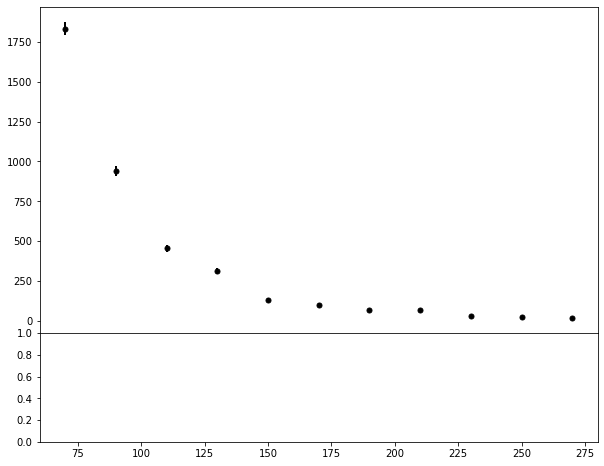

In [10]:
if not output["datasets_metadata"]:
    output = run_postprocessor(output)

for variable in output["variables"]:
    for cat in ["SR", "CRB", "CRC", "CRD", "PLJ", "b0_SR", "b0_CRB", "b0_CRC", "b0_CRD", "b0_PLJ"]:
        if "SR" in cat:
            extractor = ExtractHistData(output, 2018)
            hist_data = extractor.extract_hist_info(variable, cat, data=data, MC_BCs=mc_backgrounds1, **dd_backgrounds) # , signals=signals
        else: # cat in ["CRB", "CRC", "CRD", "PLJ"]:
            extractor = ExtractHistData(output, 2018)
            hist_data = extractor.extract_hist_info(variable, cat, data=data, MC_BCs=mc_backgrounds2)
        if hist_data.has_plot:
            plotter = Plotter(hist_data)
            plotter.plot_histogram()

In [10]:
if not output["datasets_metadata"]:
    output = run_postprocessor(output)
    
extractor = ExtractHistData(output, 2018)
hist_data = extractor.extract_hist_info("photon_pt", "SR", data=data, MC_BCs=mc_backgrounds1, **dd_backgrounds)

In [11]:
hist_data.data

array([    0., 20983., 10400.,  5629.,  3362.,  2176.,  1560.,  1099.,
         918.,   585.,   450.,   383.])

In [12]:
hist_data.syst

[0.0,
 112.91583068906834,
 76.39829941659214,
 57.61284461604489,
 42.74169536310951,
 36.08293691214637,
 30.528099572033746,
 25.05115207372609,
 22.294909766129056,
 20.27657798819695,
 17.165476202025964,
 13.259562853304123]

In [95]:
a = {}
a.values()

dict_values([])

In [86]:
np.sum(np.asarray(list(hist_data.backgrounds.values())), axis=1)

array([2933.41081638,  720.51257588,  500.81285046,   57.31677441,
       5529.04321825, 7155.39797776, 9351.2131975 , 4153.00892488])